# 1. Импорт необходимых библиотек и модулей

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
import pandas as pd
import tensorflow as tf

# print("TensorFlow version:", tf.__version__)

%matplotlib inline

# 2. Чтение данных из файла
## 2.1 Чтение экспериментальных данных из .csv

In [2]:
file_name = 'test.csv'

# TIME_CONSTANT = 0.005
# AMPL = 3.0
# F_PULSE = 20 * 10 ** (-6)
# STDDEV = 0.2

In [3]:
data = pd.read_csv(file_name, 
                   header = 0,
                   parse_dates = [0],
                   infer_datetime_format = True
                  )
data.head()

,frequency_hz,dlts_pf,f_pulse
0,1.0,0.024528,0.00002
1,1.0078626272670832,-0.200976,0.00002
2,1.0157870754417073,0.004056,0.00002
3,1.023773830598626,0.252659,0.00002
4,1.031823382634417,0.307020,0.00002


## 2.2 Подготовка данных для TensorFlow

In [4]:
dlts = tf.Variable(data.dlts_pf.to_numpy(), 
                   dtype = 'float64')

frequency = tf.Variable(data.frequency_hz.to_numpy(),
                        dtype = 'float64')

# filling_pulse = tf.Variable(data.f_pulse.mean() * 10**-6, dtype = 'float64')
filling_pulse = tf.Variable(data.f_pulse.mean(), dtype = 'float64')

In [5]:
# dlts

In [6]:
# frequency

In [7]:
filling_pulse

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.999999999999952e-05>

## 2.3 График

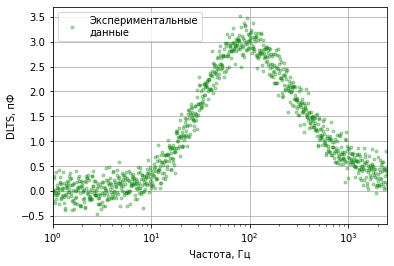

In [8]:
plt.semilogx(frequency.numpy(), dlts.numpy(), '.g', label='Экспериментальные\nданные', alpha = 0.3)
plt.grid()
plt.xlim([1, 2500])
# plt.ylim([-0.006, 0])
plt.legend()
plt.ylabel('DLTS, пФ')
plt.xlabel('Частота, Гц')
plt.show()

## 2.4 Подготовка данных

In [9]:
frequency = np.log10(frequency)
# frequency

In [10]:
scale_factor = np.max(frequency) / (np.max(dlts) - np.min(dlts))
dlts = dlts * scale_factor
# dlts

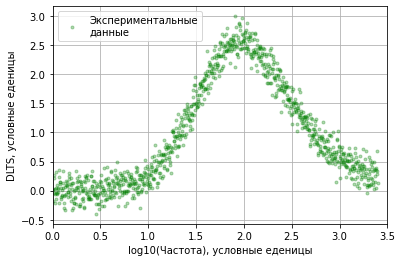

In [11]:
plt.plot(frequency, dlts, '.g', label='Экспериментальные\nданные', alpha=0.3)
plt.grid()
plt.xlim([0, 3.5])
# plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

# 3. Описание модели
Выходной сигнал коррелятора спектрометра DLS-82E определяется выражением:
\begin{equation}
    \label{eq:eq1}
    S\left(\tau,C_A,F_0, t_1\right) = C_A K_{BS} K_{LS} \phi\left(\tau,F_0,t_1\right),
\end{equation}
где  
$C_A$ - амплитуда емкостного релаксационного сигнала,  
$K_{BS}$ - масштабный коэффициент, зависящий от чувствительности емкостного моста,  
$K_{LS}$ - масштабный коэффициент селектора,  
$\tau$ - постоянная времени релаксации гулбокого уровня,  
$F_0$ - частота сканирования импульсов заполнения,  
$t_1$ - длительность импульса заполнения,  
$\phi\left(\tau,F_0,t_1\right)$ - функция определяемая выражением:  
\begin{equation}
    \label{eq:eq2}
    \phi\left(\tau,F_0,t_1\right) = 
    M \tau F_0 e^{-\frac{0.05}{\tau F_0}}
    \left(1-e^{\frac{t_1 F_0-0.45}{\tau F_0}}
    -e^{-\frac{0.5}{\tau F_0}}+
    e^{\frac{t_1 F_0-0.95}{\tau F_0}}\right),
\end{equation}
где $M$ -- масштабный множитель.

Таким образом,
$$  M = \frac{1}{\max{\left[
    \tau F_0 e^{-\frac{0.05}{\tau F_0}}
    \left(1-e^{\frac{t_1 F_0-0.45}{\tau F_0}}
    -e^{-\frac{0.5}{\tau F_0}}+
    e^{\frac{t_1 F_0-0.95}{\tau F_0}}\right)
    \right]}}
$$

# 4. Кодирование модели
## 4.1 Функция `get_phi()`
$$ \tau = 10^{time\_constant\_power} $$
$$ F_0 = 10^{frequency\_power}$$
$$ a = \tau F_0 $$
$$ b = t_1 F_0 $$
$$ exp0 = \exp{\left(\frac{-0.05}{a}\right)} $$
$$ exp1 = \exp{\left(\frac{b-0.45}{a}\right)} $$
$$ exp2 = \exp{\left(\frac{-0.5}{a}\right)} $$
$$ exp3 = \exp{\left(\frac{b-0.95}{a}\right)} $$
$$ \phi = M \cdot a \cdot exp0 \cdot \left(1.0 - exp1 - exp2 + exp3\right) $$

In [12]:
def get_phi(frequency_power, time_constant_power, M, filling_pulse):
    time_constant = tf.pow(10.0, time_constant_power)
    frequency = tf.pow(10, frequency_power)

    a = time_constant * frequency
    b = filling_pulse * frequency

    exp0 = tf.exp(-0.05 / (a))
    exp1 = tf.exp((b - 0.45) / (a))
    exp2 = tf.exp(-0.5 / (a))
    exp3 = tf.exp((b - 0.95) / (a))

    phi = M * a * exp0 * (1.0 - exp1 - exp2 + exp3)

    return phi

## 4.2 Функция `get_dlts()`
$$ DLTS = A \cdot \phi^{p\_coef} $$

In [13]:
# def get_dlts(amplitude, M, frequency_power, time_constant_power, filling_pulse):
#     dlts = amplitude * get_phi(frequency_power, 
#                                time_constant_power, 
#                                M, 
#                                filling_pulse)
    
#     return dlts

## 4.3 Определение функции потерь для DLTS (для модели). Функция `loss_dlts()`
Среднеквадратическая ошибка


In [14]:
# def loss(target_y, predicted_y):
#     return tf.reduce_mean(tf.square(target_y - predicted_y))

## 4.5 Определение модели для $\phi$

In [15]:
class PhiModel(tf.Module):
    def __init__(self, 
                 time_constant_power,
                 filling_pulse,
                 M = 5.861,
                 **kwargs):
        
        super().__init__(**kwargs)
        
        self.time_constant_power = tf.Variable(time_constant_power, 
                                               dtype='float64', 
                                               name='time constant power'
                                              )
        self.filling_pulse = tf.Variable(filling_pulse, 
                                         dtype='float64',
                                         name='filling pulse'
                                        )
        self.M = tf.Variable(M, 
                             dtype='float64',
                             name='M'
                            )
        
    def __call__(self, frequency_power):
        return get_phi(frequency_power, 
                       self.time_constant_power, 
                       self.M, 
                       self.filling_pulse)
    
    
phi_model = PhiModel(time_constant_power=tf.Variable(-3.0, dtype='float64'), 
                     filling_pulse=filling_pulse)

for i, v in enumerate(phi_model.variables):
    print(f'Variable {i}:', v)

print(phi_model(frequency_power=tf.Variable(3.0, dtype='float64')))

Variable 0: <tf.Variable 'M:0' shape=() dtype=float64, numpy=5.861>
Variable 1: <tf.Variable 'filling pulse:0' shape=() dtype=float64, numpy=1.999999999999952e-05>
Variable 2: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-3.0>
tf.Tensor(0.7666617093509145, shape=(), dtype=float64)


## 4.6 Идентификация коэффициента $M$

In [16]:
def train_M(phi_model,
            learning_rate=0.1,
            n_iters=100,
            stop_val = None,
            verbose = False
           ):
    
    prev_loss = tf.Variable(np.inf, dtype='float64')
    max_freq_pow = tf.Variable(-phi_model.time_constant_power, dtype='float64')
    
    for _ in range(n_iters):
        with tf.GradientTape() as tape:
            current_loss = 0.0 - phi_model(max_freq_pow)
            
        if verbose:
            print(_)
            print(current_loss)
            print(max_freq_pow)
        
        if stop_val is not None:
            if tf.abs(current_loss - prev_loss) < stop_val:
                break
        
        dfreq_pow = tape.gradient(current_loss, max_freq_pow)
        max_freq_pow.assign_sub(learning_rate * dfreq_pow)
        
        prev_loss = current_loss
        
    phi_model.M = phi_model.M / phi_model(max_freq_pow)

In [17]:
train_M(phi_model,
        learning_rate=0.2,
        n_iters=100,
        stop_val = 10**-10,
        verbose = True
       )

0
tf.Tensor(-0.7666617093509145, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0>
1
tf.Tensor(-0.9330581559008368, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.802874102155242>
2
tf.Tensor(-0.9859552099662315, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.676580828604517>
3
tf.Tensor(-0.9896401527850606, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.640731963100184>
4
tf.Tensor(-0.98970905667989, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6357570793749963>
5
tf.Tensor(-0.9897099286163724, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.635196461552543>
6
tf.Tensor(-0.9897099390884785, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.635135011043419>
7
tf.Tensor(-0.9897099392135181, shape=(), dtype=float64)
<tf.Variable 'Variable:0' 

In [18]:
phi_model.M

<tf.Tensor: shape=(), dtype=float64, numpy=5.921937092648238>

In [19]:
del phi_model

## 4.7 Определение модели частотного скана

In [20]:
class FeqScanModel(tf.Module):
    
    def __init__(self,
                 amplitude,
                 time_constant_power,
                 filling_pulse,
                 fit_p = False,
                 **kwargs):
        super().__init__(**kwargs)
        
        self.amplitude = tf.Variable(amplitude, dtype='float64')
        
        self.filling_pulse = tf.Variable(filling_pulse, dtype='float64')
        
        self.time_constant_power = tf.Variable(time_constant_power, dtype='float64')
    
        self.phi_model = PhiModel(time_constant_power=self.time_constant_power, 
                                  filling_pulse=self.filling_pulse)
        
        train_M(self.phi_model,
                learning_rate=0.2,
                n_iters=100,
                stop_val = 10**-10,
                verbose = False
               )
        
        self.fit_p = fit_p
        self.p_coef = tf.Variable(1.0, dtype = 'float64')
        
        

    def __call__(self, frequency_power):
        return self.amplitude * self.phi_model(frequency_power) ** self.p_coef
    
    
    def fit(self, 
            f_powers, 
            dlts_vals,
            learning_rate = 0.1,
            n_iters = 1000,
            stop_val = None,
            verbose = False
           ):
        frequency_powers = tf.Variable(f_powers, dtype='float64')
        dlts = tf.Variable(dlts_vals, dtype='float64')
        
        prev_loss = tf.Variable(np.inf, dtype='float64')
        
        for _ in range(n_iters):
            
            train_M(self.phi_model,
                    learning_rate=0.2,
                    n_iters=100,
                    stop_val = 10**-10,
                   )
        
            with tf.GradientTape() as tape:
                predicted_dlts = self.__call__(frequency_powers)
                current_loss = tf.reduce_mean(tf.square(dlts - predicted_dlts))

            if self.fit_p:
                dampl, dtime_const_pow, dp_coef = tape.gradient(current_loss, [self.amplitude, 
                                                                               self.phi_model.time_constant_power,
                                                                               self.p_coef
                                                                              ])
            else:
                dampl, dtime_const_pow = tape.gradient(current_loss, [self.amplitude, 
                                                                      self.phi_model.time_constant_power])

            self.amplitude.assign_sub(learning_rate * dampl)
            self.phi_model.time_constant_power.assign_sub(learning_rate * dtime_const_pow)
            if self.fit_p:
                self.p_coef.assign_sub(learning_rate * dp_coef)
            
            
            self.time_constant_power = self.phi_model.time_constant_power
            
            if verbose:
                print('iter #', _)
                print('amp:',self.amplitude)
                print('tau:',self.time_constant_power)
                print('M:', self.phi_model.M)
                print('p:', self.p_coef)
                print('Loss:', current_loss)
            
            if stop_val is not None:
                if tf.abs(current_loss - prev_loss) < stop_val:
                    break
                    
            prev_loss = current_loss

## 4.8 Проверка модели с $p\_coef = 1$

In [21]:
fs_model = FeqScanModel(amplitude = 2.0,
                        time_constant_power = -2.5,
                        filling_pulse = 20.0*10**-6)

In [22]:
new_frequency = tf.Variable(frequency, dtype='float64')

In [23]:
new_dlts = fs_model(new_frequency)

In [ ]:
plt.plot(frequency, dlts, '.g', label='Экспериментальные\nданные', alpha=0.3)
plt.plot(new_frequency.numpy(), new_dlts.numpy(), '--b', label='Модель')
plt.grid()
plt.xlim([0, 3.5])
# plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

In [ ]:
fs_model.fit(f_powers = tf.Variable(frequency, dtype='float64'), 
             dlts_vals = tf.Variable(dlts, dtype='float64'),
             learning_rate = 0.2,
             n_iters = 1000,
             stop_val = 10**-10,
             verbose = True
            )

In [ ]:
fs_model.amplitude / tf.Variable(scale_factor, dtype='float64')

In [ ]:
tf.pow(10, fs_model.time_constant_power)

In [ ]:
fs_model.phi_model.M

In [ ]:
model = fs_model(new_frequency)

In [ ]:
plt.plot(frequency, dlts, '.g', label='Экспериментальные\nданные',alpha=0.3)
plt.plot(new_frequency.numpy(), new_dlts.numpy(), '--b', label='Начальная модель')
plt.plot(new_frequency.numpy(), model.numpy(), 'r', label='Конечная модель')
plt.grid()
plt.xlim([0, 3.5])
# plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

In [ ]:
tf.sqrt(tf.reduce_mean(tf.square(tf.Variable(dlts, dtype='float64') - model)))

## 4.9 Проверка модели с коэффициентом $p\_coef \neq 1$

### 4.9.1 Чтение файла

In [ ]:
file_name = 'КТ117№1_п1(база 2)_2500Гц-1Гц_1пФ_+10С_-1В-2В_100мВ_20мкс_шаг_0,1.csv'

In [ ]:
data = pd.read_csv(file_name, 
                   header = 0,
                   parse_dates = [0],
                   infer_datetime_format = True
                  )
data.head()

### 4.9.1 Подготовка данных

In [ ]:
frequency = data.frequency_hz.to_numpy()
dlts = data.dlts_pf.to_numpy()

frequency = np.log10(frequency)

scale_factor = np.max(frequency) / (np.max(dlts) - np.min(dlts))
dlts = dlts * scale_factor

In [ ]:
dlts = tf.Variable(dlts, dtype = 'float64')

frequency = tf.Variable(frequency, dtype = 'float64')

filling_pulse = tf.Variable(data.f_pulse.mean() * 10**-6, dtype = 'float64')

### 4.9.2 График экспериментальных данных

In [ ]:
plt.plot(frequency.numpy(), dlts.numpy(), '.g', label='Экспериментальные\nданные', alpha=1)
plt.grid()
plt.xlim([0, 3.5])
plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

### 4.9.3 Инициализация модели

In [ ]:
fs_model = FeqScanModel(amplitude = -2.0,
                        time_constant_power = -2.5,
                        filling_pulse = 20.0*10**-6,
                        fit_p = True
                       )

In [ ]:
init_dlts = fs_model(frequency)

In [ ]:
plt.plot(frequency.numpy(), dlts.numpy(), '.g', label='Экспериментальные\nданные', alpha=0.6)
plt.plot(frequency.numpy(), init_dlts.numpy(), '--b', label='Начальная модель')
plt.grid()
plt.xlim([0, 3.5])
# plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

### 4.9.4 Идентификация модели

In [ ]:
fs_model.fit(f_powers = frequency, 
             dlts_vals = dlts,
             learning_rate = 0.2,
             n_iters = 1500,
             stop_val = 10**-10,
             verbose = True
            )

In [ ]:
final_dlts = fs_model(frequency)

In [ ]:
plt.plot(frequency.numpy(), dlts.numpy(), '.g', label='Экспериментальные\nданные', alpha=0.6)
plt.plot(frequency.numpy(), init_dlts.numpy(), '--b', label='Начальная модель')
plt.plot(frequency.numpy(), final_dlts.numpy(), 'r', label='Конечная модель')
plt.grid()
plt.xlim([0, 3.5])
# plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

In [ ]:
fs_model.amplitude / tf.Variable(scale_factor, dtype='float64')

In [ ]:
tf.pow(10, fs_model.time_constant_power)

In [ ]:
fs_model.phi_model.M

In [ ]:
fs_model.p_coef

In [ ]:
tf.sqrt(tf.reduce_mean(tf.square(final_dlts - dlts)))

# 5. Идентификация энергии активации по группе сканов
Эксперементальные данные по GaAs
## 5.1 Чтение данных

In [ ]:
def get_file_names(datasets_folder):
    return [datasets_folder + '/' + _ for _ in listdir(datasets_folder)]

def read_datasets(file_names):
    data = pd.read_csv(file_names[0],
                       header=0,
                       parse_dates=[0],
                       infer_datetime_format=True)
    
    for f_name in file_names[1:]:
        data = data.append(pd.read_csv(f_name, header=0, parse_dates=[0], 
                                       infer_datetime_format=True).loc[::10,:],
                           ignore_index = True)
    
    
    return data

In [ ]:
DATASET_PATH = '../dataset'

In [ ]:
fnames = get_file_names(DATASET_PATH)
data = read_datasets(fnames)

In [ ]:
data

In [ ]:
data = data[['frequency_hz', 'temperature_k', 'dlts_pf']]
data['rounded_temperature'] = data.temperature_k.round()
data

## 5.2 График экспериментальных данных

In [ ]:
selected = data[data.rounded_temperature == 314]

plt.semilogx(selected.frequency_hz, selected.dlts_pf, '.g', label='Экспериментальные\nданные', alpha=0.3)
plt.grid()
# plt.xlim([0, 3.5])
# plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

## 5.3 Подготовка данных

In [ ]:
frequency = data.frequency_hz.to_numpy()
dlts = data.dlts_pf.to_numpy()
temperature = data.temperature_k.to_numpy()


frequency_power = np.log10(frequency)

scale_factor = np.max(frequency) / (np.max(dlts) - np.min(dlts))
dlts = dlts * scale_factor


frequency_power = tf.Variable(frequency_power, dtype='float64')
dlts = tf.Variable(dlts, dtype='float64')
temperature = tf.Variable(temperature, dtype='float64')

In [ ]:
frequency

In [ ]:
frequency_power

In [ ]:
temperature

## 5.4 Модель

$$ e_n = BT^2\exp\left(\frac{-\Delta E}{kT} \right) $$
$$ \tau = \frac{1}{e_n} $$
$$ time\_constant\_power = \log_{10}\tau = \frac{\log_e\tau}{\log_e10}$$

$$ F_0 = 10^{frequency\_power}$$
$$ a = \tau F_0 $$
$$ b = t_1 F_0 $$
$$ exp0 = \exp{\left(\frac{-0.05}{a}\right)} $$
$$ exp1 = \exp{\left(\frac{b-0.45}{a}\right)} $$
$$ exp2 = \exp{\left(\frac{-0.5}{a}\right)} $$
$$ exp3 = \exp{\left(\frac{b-0.95}{a}\right)} $$

$$  M = \frac{1}{\max{\left[
    \tau F_0 e^{-\frac{0.05}{\tau F_0}}
    \left(1-e^{\frac{t_1 F_0-0.45}{\tau F_0}}
    -e^{-\frac{0.5}{\tau F_0}}+
    e^{\frac{t_1 F_0-0.95}{\tau F_0}}\right)
    \right]}}
$$

$$ \phi = M \cdot a \cdot exp0 \cdot \left(1.0 - exp1 - exp2 + exp3\right) $$

$$ S\left(\tau,A,F_0, t_1\right) = A \phi\left(\tau,F_0,t_1\right) $$

In [ ]:
class DeepLevelModel(tf.Module):
    
    def get_time_constant_power(self, temperature):
        k = tf.Variable(8.617*10**-5, dtype='float64')

        time_constant = 1 / ( self.pre_exp_factor * temperature * temperature * tf.math.exp(-self.energy / (k * temperature) ))

        time_constant_power = tf.math.log(time_constant) / tf.math.log(tf.Variable(10.0, dtype='float64'))

        return time_constant_power
    
    
    def get_phi(self, frequency_power, time_constant_power):
        time_constant = tf.pow(10.0, time_constant_power)
        frequency = tf.pow(10.0, frequency_power)

        a = time_constant * frequency
        b = self.filling_pulse * frequency

        exp0 = tf.exp(-0.05 / (a))
        exp1 = tf.exp((b - 0.45) / (a))
        exp2 = tf.exp(-0.5 / (a))
        exp3 = tf.exp((b - 0.95) / (a))

        phi = self.M * a * exp0 * (1.0 - exp1 - exp2 + exp3)

        return phi
    
    
    def train_M(self,
                time_constant_powers,
                learning_rate=0.1,
                n_iters=100,
                stop_val = None,
                verbose = False
               ):

        prev_loss = tf.Variable(np.inf, dtype='float64')
        max_freq_pow = tf.Variable(-time_constant_powers, dtype='float64')

        for _ in range(n_iters):
            with tf.GradientTape() as tape:
                current_loss = 0.0 - self.get_phi(max_freq_pow, time_constant_powers)

            if verbose:
                print(_)
                print(current_loss)
                print(max_freq_pow)

            if stop_val is not None:
                if tf.abs(current_loss - prev_loss) < stop_val:
                    break

            dfreq_pow = tape.gradient(current_loss, max_freq_pow)
            max_freq_pow.assign_sub(learning_rate * dfreq_pow)

            prev_loss = current_loss

        return self.M / self.get_phi(max_freq_pow, time_constant_powers)
    
    
    def __init__(self,
                 amplitude,
                 energy,
                 pre_exp_factor,
                 filling_pulse,
                 fit_p = False,
                 **kwargs):
        super().__init__(**kwargs)
        
        self.amplitude = tf.Variable(amplitude, dtype='float64')
        self.energy = tf.Variable(energy, dtype='float64')
        self.pre_exp_factor = tf.Variable(pre_exp_factor, dtype='float64')
        self.filling_pulse = tf.Variable(filling_pulse, dtype='float64')
        
        self.fit_p = fit_p
        self.p_coef = tf.Variable(1.0, dtype='float64')
        
        self.M = tf.Variable(5.861, dtype='float64')
        
        
    def __call__(self,frequency_power, temperature):
        time_constant_powers = self.get_time_constant_power(temperature)
        
        def get_M(time_constant_powers):
            
            M = self.train_M(time_constant_powers,
                             learning_rate=0.2,
                             n_iters=100,
                             stop_val = 10**-10,
                             verbose = False
                            )
            
#             print(M)
            
            return M
        
        self.M = tf.map_fn(get_M, time_constant_powers)
        
#         print(self.get_phi(frequency_power, time_constant_powers))
        
        return self.amplitude * self.get_phi(frequency_power, time_constant_powers)
    
    
    def fit(self,
            f_powers, 
            temp_vals,
            dlts_vals,
            
            learning_rate = 0.1,
            n_iters = 1000,
            stop_val = None,
            verbose = False
           ):
        
        frequency_powers = tf.Variable(f_powers, dtype='float64')
        temp = tf.Variable(temp_vals, dtype='float64')
        dlts = tf.Variable(dlts_vals, dtype='float64')
        
        prev_loss = tf.Variable(np.inf, dtype='float64')
        
        for _ in range(n_iters):
        
            with tf.GradientTape() as tape:
                predicted_dlts = self.__call__(frequency_power, temp)
                current_loss = tf.reduse_mean(tf.square(dlts-predicted_dlts))
                
                if self.fit_p:
                    d_ampl, denergy, dpre_exp_factor, pd_coef = tape.gradient(current_loss, [self.amplitude,
                                                                                             self.energy,
                                                                                             self.pre_exp_factor,
                                                                                             self.p_coef
                                                                                            ])
                else:
                    d_ampl, denergy, dpre_exp_factor = tape.gradient(current_loss, [self.amplitude,
                                                                                    self.energy,
                                                                                    self.pre_exp_factor
                                                                                   ])

            self.amplitude.assign_sub(learning_rate * dampl)
            self.energy.assign_sub(learning_rate * denergy)
            self.pre_exp_factor.assign_sub(learning_rate * dpre_exp_factor)
            
            
            if self.fit_p:
                self.p_coef.assign_sub(learning_rate * dp_coef)
                                           
            
            if verbose:
                print('iter #', _)
                print('A:',self.amplitude)
                print('E:',self.energy)
                print('B:', self.pre_exp_factor)
                print('M:', self.phi_model.M)
                print('p:', self.p_coef)
                print('Loss:', current_loss)
            
            if stop_val is not None:
                if tf.abs(current_loss - prev_loss) < stop_val:
                    break
                    
            prev_loss = current_loss

## 5.5 Инициализация и проверка модели

In [ ]:
energy = tf.Variable(-0.7, dtype='float64')
pre_exp_factor = tf.Variable(1*10**-13, dtype='float64')
filling_pulse = tf.Variable(2 * 10 ** -5, dtype='float64')
amplitude =tf.Variable(3.5, dtype='float64')

deep_level_model = DeepLevelModel(amplitude = amplitude,
                                  energy = energy,
                                  pre_exp_factor = pre_exp_factor,
                                  filling_pulse = filling_pulse,
                                  fit_p = False)

res  = deep_level_model(frequency_power, temperature)

In [ ]:
print(frequency_power)

In [ ]:
print(temperature)

In [ ]:
pd.DataFrame(deep_level_model.M).isna().any()

In [ ]:
pd.DataFrame(res).isna().any()

In [ ]:
pd.DataFrame(res).isna().sum()

In [ ]:
res

## 5.6 Идентификация модели

In [ ]:
deep_level_model.fit(frequency_power, 
                     temperature,
                     dlts,
                     
                     learning_rate = 0.1,
                     n_iters = 1000,
                     stop_val = 10.0**-10,
                     verbose = True
                    )